# 파인튜닝 

In [2]:
from pyannote.database import registry, FileFinder

registry.load_database("database.yml")
dataset = registry.get_protocol("ALI.SpeakerDiarization.koko", {"audio": FileFinder()})

'AMI-SDM.SpeakerDiarization.only_words' found in /workspace/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDiarization.mini' found in /workspace/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.only_words' found in /workspace/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.mini' found in /workspace/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.word_and_vocalsounds' found in /workspace/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'ALI.SpeakerDiarization.koko' found in /workspace/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


In [ ]:
!PYANNOTE_DATABASE_CONFIG= "database.yml" pyannote-database info ALI.SpeakerDiarization.koko

/bin/bash: line 1: database.yml: command not found


In [9]:
# Importing the base segmentation model for fine-tuning
from pyannote.audio import Pipeline
from dotenv import load_dotenv
import torch
import os

load_dotenv()
pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=os.getenv("HUGGINGFACE_TOKEN")) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_pipeline = pretrained_pipeline.to(device)

In [9]:
from pyannote.metrics.diarization import DiarizationErrorRate

metric = DiarizationErrorRate()

for file in dataset.test():
    # apply pretrained pipeline
    file["pretrained pipeline"] = pretrained_pipeline(file)

    # evaluate its performance
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

/workspace/.venv/lib/python3.10/site-packages/pyannote/audio/utils/reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
/workspace/.venv/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = sequences.std(dim=-1, correction=1)


The pretrained pipeline reaches a Diarization Error Rate (DER) of 29.8% on ALI.SpeakerDiarization.koko test set.


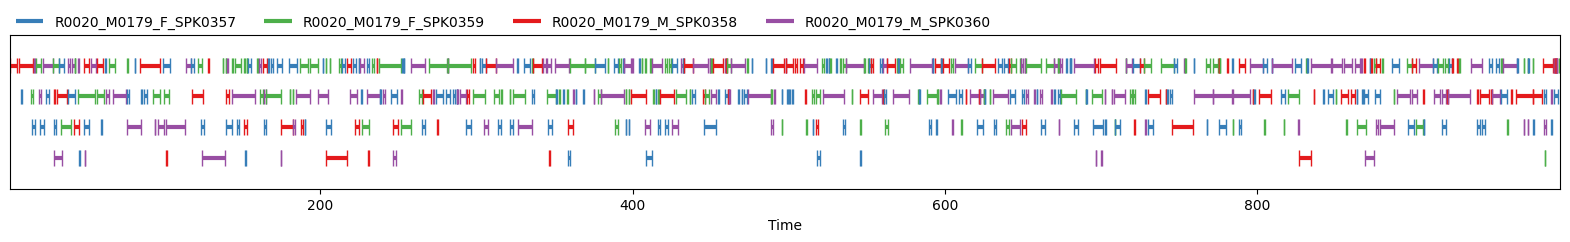

In [10]:
file['annotation'] 

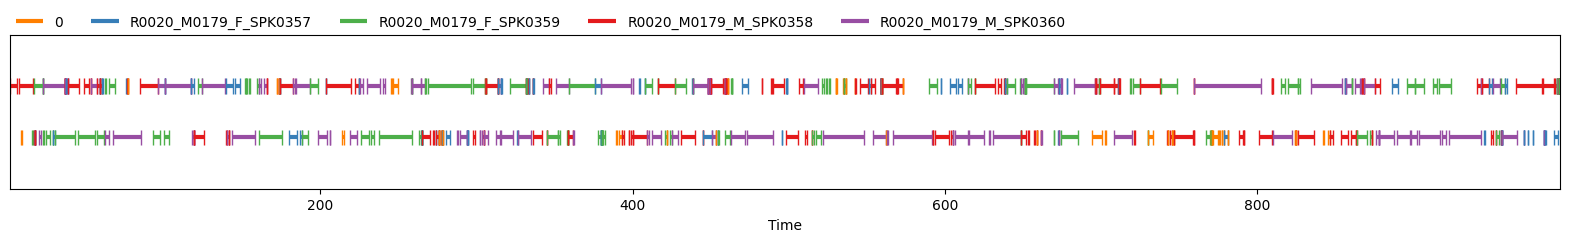

In [11]:
file['pretrained pipeline']

# Fine-tuning the segmentation model

In [4]:
from pyannote.audio import Model
import os
import torch
from dotenv import load_dotenv

load_dotenv()
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=os.getenv("HUGGINGFACE_TOKEN"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [6]:
from pyannote.audio.tasks import Segmentation
task = Segmentation(
    dataset, 
    duration=model.specifications.duration, 
    max_num_speakers=len(model.specifications.classes), 
    batch_size=32,
    num_workers=8, 
    loss="bce", 
    vad_loss="bce")
model.task = task
model.prepare_data()
model.setup()

/workspace/.venv/lib/python3.10/site-packages/pyannote/audio/tasks/segmentation/speaker_diarization.py:176: UserWarning: `max_num_speakers` has been deprecated in favor of `max_speakers_per_chunk`.
  warnings.warn(
/workspace/.venv/lib/python3.10/site-packages/pyannote/audio/tasks/segmentation/speaker_diarization.py:180: UserWarning: `loss` has been deprecated and has no effect.
  warnings.warn("`loss` has been deprecated and has no effect.")
/workspace/.venv/lib/python3.10/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))
/workspace/.venv/lib/python3.10/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))
/workspace/.venv/lib/python3.10/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed

In [7]:
# this takes approximately 15min to run on Google Colab GPU
from types import MethodType
from torch.optim import Adam
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)

# we use Adam optimizer with 1e-4 learning rate
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)

model.configure_optimizers = MethodType(configure_optimizers, model)

# we monitor diarization error rate on the validation set
# and use to keep the best checkpoint and stop early
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor=monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False,
)
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False,
)

callbacks = [RichProgressBar(), checkpoint, early_stopping]

# we train for at most 20 epochs (might be shorter in case of early stopping)
from pytorch_lightning import Trainer
trainer = Trainer(accelerator="gpu", 
                  callbacks=callbacks, 
                  max_epochs=20,
                  gradient_clip_val=0.5)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃ Mode  ┃       In sizes ┃                          Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ train │ [1, 1, 160000] │                       [1, 60, 589] │
│ 1 │ lstm              │ LSTM             │  1.4 M │ train │   [1, 589, 60] │  [[1, 589, 256], [[8, 1, 128], [8, │
│   │                   │                  │        │       │                │                          1, 128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │ train │              ? │                                  ? │
│ 3 │ classifier        │ Linear           │    387 │ train │  [1, 589, 128] │                        [1, 589, 3] │
│ 4 │ activation        │ Sigmoid          │      0 │ train │    [1, 589, 3] │                        [1, 589, 3] │
│ 5 │ validation_metric │ MetricCollection │      0 │ train │              ? │                                  ? │
└───┴───────────────────┴──────────────────┴────────┴───────┴────────────────┴────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0

Output()

/workspace/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has 
`__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be 
inaccurate if each worker is not configured independently to avoid having duplicate data.

`Trainer.fit` stopped: `max_epochs=20` reached.


In [9]:
finetuned_model = checkpoint.best_model_path

#to file
import shutil
shutil.move(finetuned_model, "finetuned_model.ckpt")


'finetuned_model.ckpt'

In [ ]:
# 체크포인트 로딩 시 실행.
# we load the best model


# from pyannote.audio import Model
# import torch

# finetuned_model = "finetuned_model.ckpt"
# model = Model.from_pretrained(finetuned_model)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)



### Optimizing the pipeline hyper parameters

In [10]:
pretrained_hyperparameters = pretrained_pipeline.parameters(instantiated=True)
pretrained_hyperparameters

{'segmentation': {'min_duration_off': 0.0},
 'clustering': {'method': 'centroid',
  'min_cluster_size': 12,
  'threshold': 0.7045654963945799}}

In [ ]:
# this takes approximately 5min to run on Google Colab GPU
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.pipeline import Optimizer

pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    clustering="OracleClustering",  
)
# as reported in the technical report, min_duration_off can safely be set to 0.0
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

optimizer = Optimizer(pipeline)
dev_set = list(dataset.development())

iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 20: break   # 50 iterations should give slightly better results

/workspace/.venv/lib/python3.10/site-packages/pyannote/pipeline/parameter.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  return trial.suggest_uniform(name, self.low, self.high)
/workspace/.venv/lib/python3.10/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))
